In [14]:
#Import relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


In [10]:
# --- Import of prestation data ---

#Read the data
df_pres = pd.read_csv('data/transport_performance.csv', sep=';')

#Initialise prestation data
df_pres['Periods'] = pd.to_numeric(df_pres['Periods'], errors='coerce')
df_pres['Transport performance (billion passenger kilometres )'] = pd.to_numeric(df_pres['Transport performance (billion passenger kilometres )'], errors='coerce')

#Rename columns
df_pres.rename({'Transport performance (billion passenger kilometres )': 'Total travel'}, axis=1, inplace=True)

#Drop unnesecary columns
df_pres.drop('Margins', axis=1, inplace=True)
df_pres.drop('Population', axis=1, inplace=True)

df_pres.head()


,Modes of travel,Region characteristics,Periods,Total travel
0,Total,The Netherlands,2018,218.1
1,Total,The Netherlands,2019,218.8
2,Total,The Netherlands,2020,152.0
3,Total,The Netherlands,2021,168.4
4,Total,The Netherlands,2022,186.9


In [11]:
# --- Import of mobility data ---

df_mob = pd.read_csv('data/mobility_trends.csv', sep=';')

#initialise data

df_mob['ds'] = df_mob['Periods'].str[:-1] + '-01-01'
df_mob['ds'] = pd.to_datetime(df_mob['ds'])
df_mob['Stages per person per day (average) (number)'] = df_mob['Stages per person per day (average) (number)'].astype(float)

df_mob.head()


,Sex,Age,Modes of travel,Travel motives,Margins,Periods,Stages per person per day (average) (number),Distance travelled per stage (average) (passenger kilometres),Average travel time per stage (Minutes),ds
0,Total male and female,Total,Total,Total,Value,1999*,3.41,10.96,23.72,1999-01-01
1,Total male and female,Total,Total,Total,Value,2000*,3.35,11.00,23.73,2000-01-01
2,Total male and female,Total,Total,Total,Value,2001*,3.30,10.99,23.67,2001-01-01
3,Total male and female,Total,Total,Total,Value,2002*,3.30,11.01,23.49,2002-01-01
4,Total male and female,Total,Total,Total,Value,2003*,3.30,11.04,23.65,2003-01-01


In [12]:
# --- Model 1 forecasting ---

#Create dataframe for model 1
df_m1 = df_mob[(df_mob['Modes of travel']=='Total') & (df_mob['Travel motives']== 'Total')].copy()

df_m1['ds'] = df_mob['Periods'].str[:-1] + '-01-01'
df_m1['ds'] = pd.to_datetime(df_mob['ds'])


# df_m1['Stages per person per day (average) (number)'] = df_m1['Stages per person per day (average) (number)'].astype(float)
# df_m1['Distance travelled per stage (average) (passenger kilometres)'] = df_m1['Distance travelled per stage (average) (passenger kilometres)'].astype(float)
df_m1['y'] = df_m1['Stages per person per day (average) (number)'].astype(float) * df_m1['Distance travelled per stage (average) (passenger kilometres)'].astype(float)

#Add regressor to dataframe to include covid as special event
df_m1['covid'] = 0
df_m1.loc[(df_m1['Periods'] == 2020), 'covid'] = 1
df_m1.loc[(df_m1['Periods'] == 2021), 'covid'] = 0.5

#Forecast the first model using prophet
m1 = Prophet()
m1.add_regressor('covid')
m1.fit(df_m1)
prediction_m1 = m1.make_future_dataframe(periods=5, freq='Y')
prediction_m1['covid'] = 0

forecast_m1 = m1.predict(prediction_m1)

C:\Users\raxo1\AppData\Local\Temp\ipykernel_26928\229275183.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_m1.loc[(df_m1['Periods'] == 2021), 'covid'] = 0.5
10:29:35 - cmdstanpy - INFO - Chain [1] start processing
10:29:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\raxo1\anaconda3\envs\TIL_programming\lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


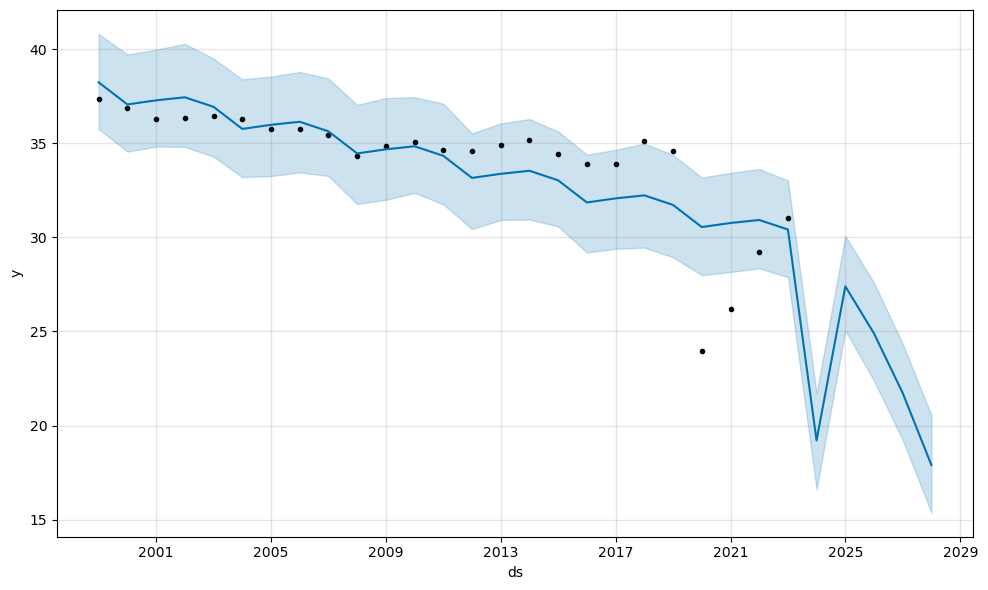

  0%|          | 0/11 [00:00<?, ?it/s]10:30:39 - cmdstanpy - INFO - Chain [1] start processing
10:30:40 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]10:30:40 - cmdstanpy - INFO - Chain [1] start processing
10:30:51 - cmdstanpy - INFO - Chain [1] done processing
 18%|█▊        | 2/11 [00:12<01:04,  7.22s/it]10:30:52 - cmdstanpy - INFO - Chain [1] start processing
10:31:04 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 3/11 [00:25<01:18,  9.82s/it]10:31:04 - cmdstanpy - INFO - Chain [1] start processing
10:31:18 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▋      | 4/11 [00:39<01:20, 11.51s/it]10:31:19 - cmdstanpy - INFO - Chain [1] start processing
10:31:34 - cmdstanpy - INFO - Chain [1] done processing
 45%|████▌     | 5/11 [00:55<01:18, 13.09s/it]10:31:34 - cmdstanpy - INFO - Chain [1] start processing
10:31:35 - cmdstanpy - INFO - Chain [1] done processing
 55%|█████▍    | 6/11 [00:55<00:44,  8.81s/it]10:31:35


Performance Metrics head:
            horizon        mse      rmse       mae      mape     mdape  \
0   0 days 06:00:00   0.719989  0.848522  0.552933  0.017577  0.008557   
1   0 days 18:00:00   3.682539  1.918994  1.356189  0.038049  0.015291   
2 365 days 06:00:00  17.011160  4.124459  2.285786  0.087393  0.025748   

      smape  coverage  
0  0.017212  0.500000  
1  0.037246  0.200000  
2  0.075513  0.166667  


In [16]:
# --- Results of forecast model 1 ---

#Plot figure with results
fig1 = m1.plot(forecast_m1)
plt.show()

#Do cross_validation to check accuracy of model
df_cv_m1 = cross_validation(
    model=m1,
    initial='365.25 D',
    period='730.5 D',
    horizon='365.25 D'
)

df_p_m1 = performance_metrics(df_cv_m1)

#Print results of performance metrics
print("\nPerformance Metrics head:")
print(df_p_m1.head())

In [17]:
# --- Forecast second model with prestation data ---

#Restructing of data
df_m2 = df_pres[(df_pres['Modes of travel']=='Total') & (df_pres['Region characteristics']=='The Netherlands')].copy()
df_m2 = df_m2.rename(columns={'Total travel': 'y'})

df_m2['ds'] = df_m2['Periods'].astype(str) + '-01-01'
df_m2['ds'] = pd.to_datetime(df_m2['ds'])

#Add covid as an event to the model
df_m2['covid'] = 0
df_m2.loc[(df_m2['Periods'] == 2020), 'covid'] = 1
df_m2.loc[(df_m2['Periods'] == 2021), 'covid'] = 0.5

#Fit the model
m2 = Prophet(changepoint_prior_scale=0.1)
m2.add_regressor('covid')
m2.fit(df_m2)

#Predict future
prediction_m2 = m2.make_future_dataframe(periods=10, freq='YE')
prediction_m2['covid'] = 0
forecast_m2 = m2.predict(prediction_m2)

C:\Users\raxo1\AppData\Local\Temp\ipykernel_26928\397908819.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_m2.loc[(df_m2['Periods'] == 2021), 'covid'] = 0.5
10:31:38 - cmdstanpy - INFO - Chain [1] start processing
10:31:38 - cmdstanpy - INFO - Chain [1] done processing


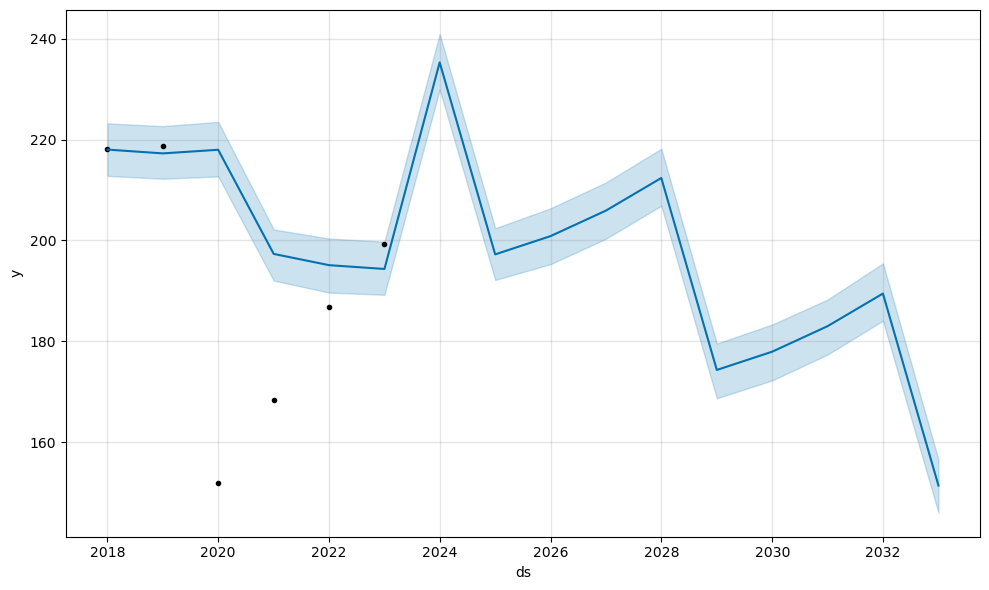

In [18]:
fig2 = m2.plot(forecast_m2)
plt.show()

In [19]:
df_p = performance_metrics(df_cv)
df_p.head()

NameError: name 'df_cv' is not defined

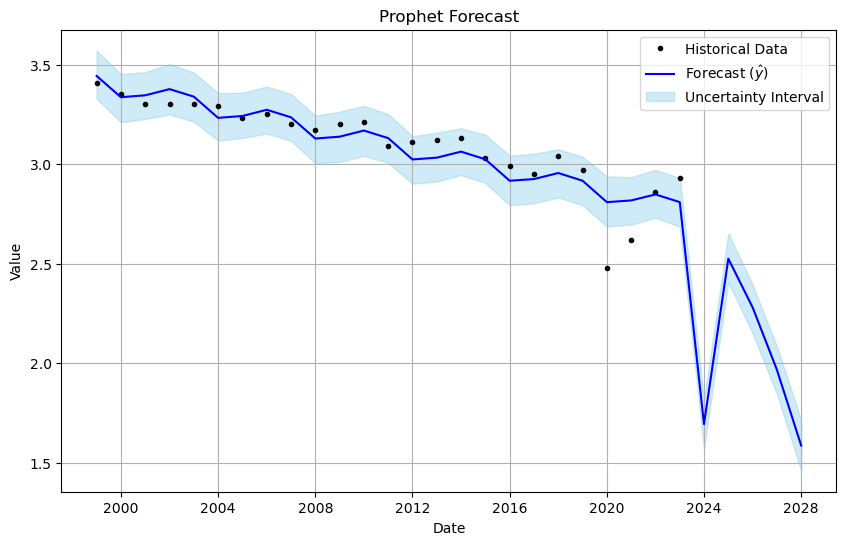

In [ ]:
# --- OLD ---

# ... your code to fit and predict ...
forecast = m.predict(prediction)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the historical data (optional, only if df_forecast contains 'y')
plt.plot(df_forecast['ds'], df_forecast['y'], 'k.', label='Historical Data')

# Plot the forecast line
plt.plot(forecast['ds'], forecast['yhat'], 'b-', label='Forecast ($\hat{y}$)')

# Plot the uncertainty interval (shaded area)
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    color='skyblue',
    alpha=0.4,
    label='Uncertainty Interval'
)

# Add labels and title
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

df_cv_m2 = cross_validation(
    model=m2,
    initial='365 D',
    period='730 D',
    horizon='365 D'
)

print(df_cv_m2.head())

df_p_m2 = performance_metrics(df_cv_m2)

print("\nPerformance Metrics head:")
print(df_p_m2.head())


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]10:06:40 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:04<00:04,  4.24s/it]10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:04<00:00,  2.49s/it]


          ds        yhat  yhat_lower  yhat_upper      y     cutoff
0 2021-01-01  295.250074  295.250073  295.250074  168.4 2020-01-02
1 2023-01-01  177.224534  175.114963  179.554542  199.3 2022-01-01

Performance Metrics head:
   horizon         mse      rmse       mae      mape     mdape    smape  \
0 365 days  8289.13368  91.04468  74.46277  0.432016  0.432016  0.33222   

   coverage  
0       0.0  
